Мета завдання:
Розробити інтелектуальний модуль, що використовує нечітку логіку для 
виявлення схожих записів у базі даних, навіть якщо терміни мають різні 
варіації написання, скорочення, орфографічні помилки або альтернативні 
форми. Завдання спрямоване на формування практичних навичок роботи з 
нечіткими множинами, функціями належності та нечітким виведенням для 
класифікації і групування схожих записів.

In [6]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz
import fuzzy
import matplotlib.pyplot as plt
from tabulate import tabulate
from Levenshtein import distance as levenshtein_distance

In [10]:
ds = pd.read_csv('../data/room_type.csv')
ds.head()

,Expedia,Booking.com
0,"Deluxe Room, 1 King Bed",Deluxe King Room
1,"Standard Room, 1 King Bed, Accessible",Standard King Roll-in Shower Accessible
2,"Grand Corner King Room, 1 King Bed",Grand Corner King Room
3,"Suite, 1 King Bed (Parlor)",King Parlor Suite
4,"High-Floor Premium Room, 1 King Bed",High-Floor Premium King Room


In [11]:
ds.count()

Expedia        103
Booking.com    103
dtype: int64

In [13]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Expedia      103 non-null    object
 1   Booking.com  103 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


те шо я побачив на кеґлі - там попарно порівнюють оці записи. хотя воно не сильно "пошук по бд", але на безвір'ї і Тома вірянин😇

In [80]:
class IntelektualnyiModul:
  def __init__(self, soundex: int = 4, threshold: float = 0.75):
    self.soundex = fuzzy.Soundex(soundex)
    self.weights = [
      (self.token_sort_ratio, 0.5),
      (self.soundex_similarity, 0.5),
      (self.damerau_levenshtein_distance, 0.0)
    ]
    
    self.threshold = threshold
    self.decisions = [
      "Yess🎀", "Nooo🚬",
    ]
  
  def soundex_similarity(self, str1, str2) -> int:
    return int(self.soundex(str1) == self.soundex(str2)) * 100
  
  def similarity_weighted(self, str1, str2, jw_: float = None, soundex_: int = None, levenshtein_: int = None) -> float:
    if jw_ is None:
      jw_ = self.token_sort_ratio(str1, str2)
    if soundex_ is None:
      soundex_ = self.soundex_similarity(str1, str2)
    if levenshtein_ is None:
      levenshtein_ = self.damerau_levenshtein_distance(str1, str2)
    
    similarity = (
      jw_ * 0.5 + 
      soundex_ * 0.5 + 
      levenshtein_ * 0.0
    )
    return round(similarity, 2)
  def similarity_weighted_V2(self, str1, str2, weights: list = None) -> float:
    if weights is None:
      weights = self.weights
    similarity = sum([w[0](str1, str2) * w[1] for w in weights])
    return round(similarity, 2) 
  
  def hard_decision(self, similarity, strong: bool = False) -> str:
    result_index = (similarity < self.threshold) if strong else (similarity <= self.threshold)
    return self.decisions[result_index]
  
  @staticmethod
  def damerau_levenshtein_distance(str1, str2) -> int:
    return levenshtein_distance(str1, str2)
  
  @staticmethod
  def token_sort_ratio(str1, str2) -> float:
    return fuzz.token_sort_ratio(str1, str2) / 100

  def compare(self, str1, str2) -> list:
    """
    Returns:
        list: soundex_sim, damerau-levenshtein, 
    """
    return [
      self.soundex_similarity(str1, str2),
      self.damerau_levenshtein_distance(str1, str2),
    ]
  def compare_row(self, row: pd.Series) -> list:
    str1, str2 = row
    return self.compare(str1, str2)
  
modul = IntelektualnyiModul()

In [56]:
print(modul.soundex_similarity("Hello", "Hella"))
print(modul.soundex_similarity("Hello", "Hell no"))

100
0


перша буква ріііізна, йоооой

In [39]:
print(modul.damerau_levenshtein_distance("Hello", "Hello"))
print(modul.damerau_levenshtein_distance("Hello", "Hella"))
print(modul.damerau_levenshtein_distance("Hello", "Helo"))


0
1
1


In [53]:
print(modul.token_sort_ratio("Hello", "Hello"))
print(modul.token_sort_ratio("Hello", "Hellya"))
print(modul.token_sort_ratio("Hello", "Hell no"))

1.0
0.7272727272727273
0.8333333333333335


In [66]:
modul.similarity_weighted(
  "Hello",
  "Hell no",
  # jw_=0.83333,
  # soundex_=0,
)

0.42

In [75]:
similarity = modul.similarity_weighted_V2(
  "Hello",
  "Hell no",
  weights = [
    (modul.token_sort_ratio, 0.5),
    (modul.soundex_similarity, 0.25),
    (modul.damerau_levenshtein_distance, 0.25)
  ]
)
similarity

0.92

In [88]:
modul.threshold = 0.92
modul.hard_decision(
  similarity,
  strong=True
)

'Yess🎀'

### чіткі рішення є, тепер м'ягеенькі🍦

ооо оце мені подобаєця

окі, я подивився на приклад, і в мене нема стільки полів шоб попарно їх перевіряти, вони в мене по парах і стоять то, тому перевірим пари

In [40]:
ds.shape

(103, 2)

перевірити 103 пари, чи вдать шо їх більше і зробить пошук

пошук по чому?..

запхаєм наші лапи🐾 в датасет

In [45]:
type(ds.iloc[0])

pandas.core.series.Series

In [44]:
str1, str2 = ds.iloc[0]
str1, str2

('Deluxe Room, 1 King Bed', 'Deluxe King Room')

In [63]:
modul.compare(str1, str2)

[0, 12]

In [64]:
modul.compare_row(ds.iloc[0])

[0, 12]

### м'ягкі рішення тут 👇

In [122]:
class MembershipFunctions:
  def __init__(self):
    pass
  
  @staticmethod
  def apply(x_array, function):
    return [function(x) for x in x_array]

  @staticmethod
  def triangular(x, params: list):
    a, b, c = params
    if x < a:
      return 0
    elif x >= a and x < b:
      return (x - a) / (b - a)
    elif x >= b and x < c:
      return (c - x) / (c - b)
    else:
      return 0 
    
  @staticmethod
  def plot(x, membership, label) -> None:
    plt.figure(figsize=(10, 6))
    plt.plot(x, membership, label=label)
    plt.title('Функції належності для ступеня схожості')
    plt.xlabel('Схожість (%)')
    plt.ylabel('Ступінь належності')
    plt.legend()
    plt.grid(True)
    plt.show()
  @staticmethod
  def plot_many(x, mem_labels: list) -> None:
    plt.figure(figsize=(10, 6))
    for membership, label in mem_labels:
      plt.plot(x, membership, label=label)
    plt.title('Функції належності для ступеня схожості')
    plt.xlabel('Схожість (%)')
    plt.ylabel('Ступінь належності')
    plt.legend()
    plt.grid(True)
    plt.show()
membership = MembershipFunctions()

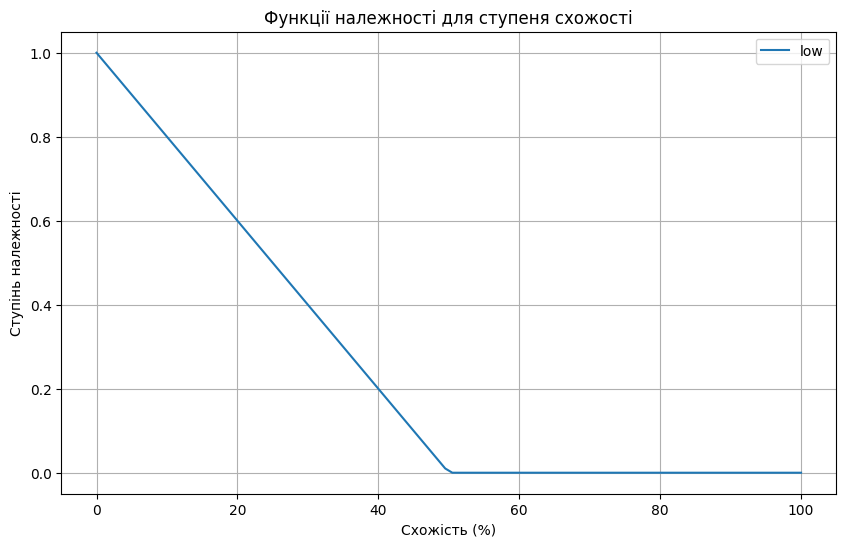

In [123]:
X = np.linspace(0, 100, 100)

low_rules = [0, 0, 50]
low_member = membership.apply(X, lambda x: membership.triangular(x, low_rules))
membership.plot(X, low_member, "low")

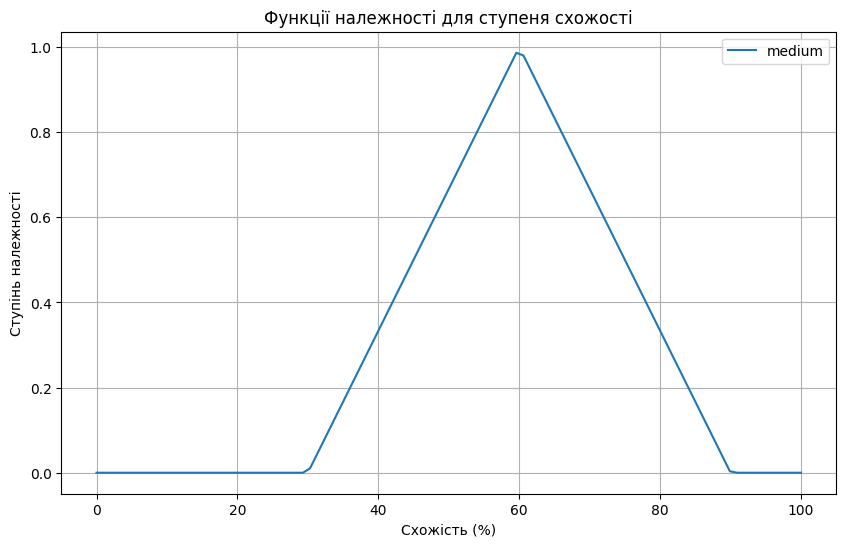

In [124]:
medium_rules = [30, 60, 90]
medium_member = membership.apply(X, lambda x: membership.triangular(x, medium_rules))
membership.plot(X, medium_member, "medium")

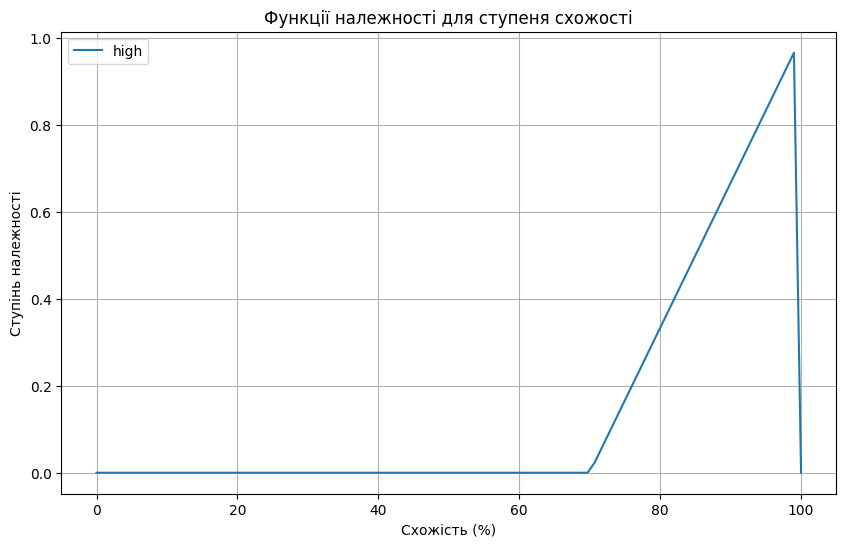

In [125]:
high_rules = [70, 100, 100]
high_member = membership.apply(X, lambda x: membership.triangular(x, high_rules))
membership.plot(X, high_member, "high")

а якшо запихнуть то всьо в окремий клас?

In [141]:
class SoftDecider:
  def __init__(self, name: str, rules: list, membership_function = None):
    self.name = name
    self.rules = rules
    self.mem_func = membership_function if membership_function is not None else MembershipFunctions.triangular
    
  def decide(self, x) -> float:
    return self.mem_func(x, self.rules)
  
  def decide_array(self, X):
    return MembershipFunctions.apply(X, lambda x: self.mem_func(x, self.rules))
    
  def plot_decider(self, X):
    member = self.decide_array(X)
    membership.plot(X, member, self.name)
    
  def plot_many_deciders(X, deciders):
    MembershipFunctions.plot_many(
      X, [(d.decide_array, d.name) for d in deciders]
    )
    return 

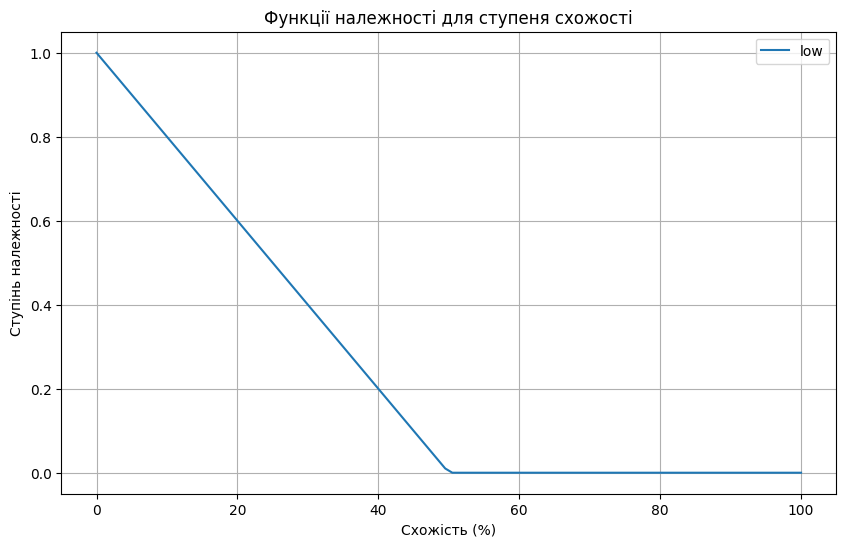

In [139]:
low_decider = SoftDecider(
  "low", [0, 0, 50]
)
low_decider.plot_decider(X)

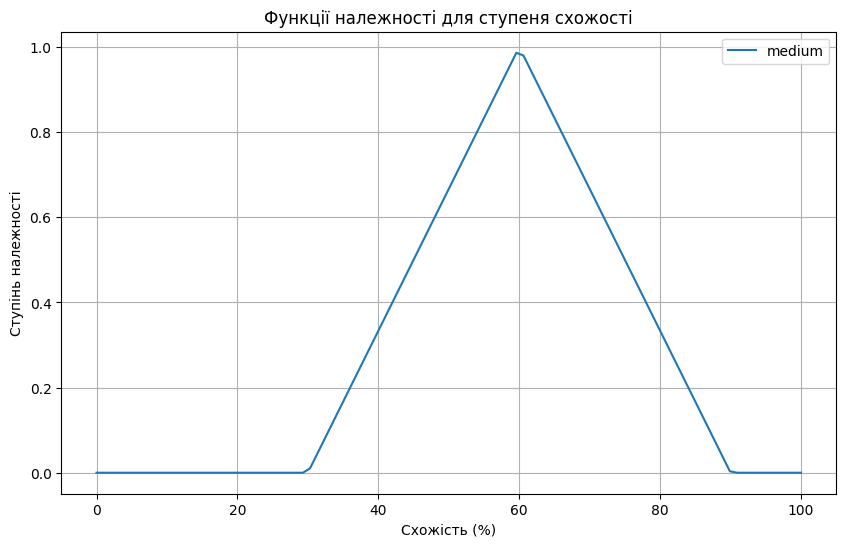

In [135]:
medium_decider = SoftDecider(
  "medium", [30, 60, 90]
)
medium_decider.plot_decider(X)

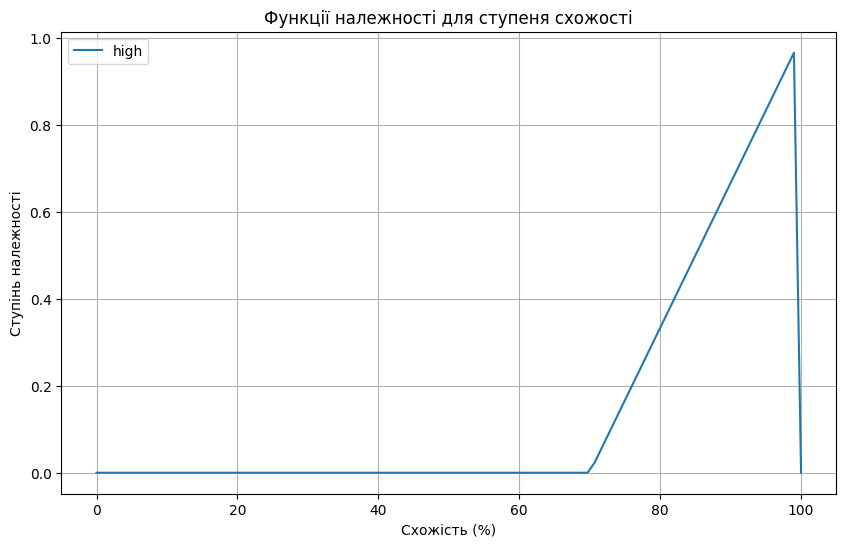

In [136]:
high_decider = SoftDecider(
  "high", [70, 100, 100]
)
high_decider.plot_decider(X)

ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

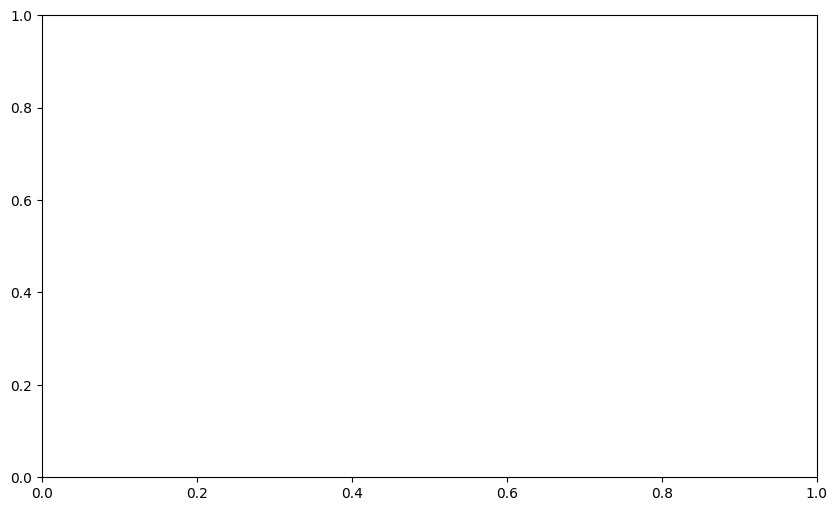

In [142]:
SoftDecider.plot_many_deciders(
  X, [low_decider, medium_decider, high_decider]
)

In [ ]:
class DeciderPipe:
  def __init__(self, name, deciders: list[SoftDecider], X: np.ndarray = None):
    self.name = name
    self.deciders = deciders
    if X is None:
      self.X = np.linspace(0, 100, 100)
    
  def decide(self, x) -> list[float]:
    return [decider.decide(x) for decider in self.deciders]
  
  def plot(self) -> None:
    plt.figure(figsize=(10, 6))
    for decider in self.deciders:
      plt.plot(self.X, decider.decide_array(X), label=decider.name)
    plt.title('Функції належності для ступеня схожості')
    plt.xlabel('Схожість (%)')
    plt.ylabel('Ступінь належності')
    plt.legend()
    plt.grid(True)
    plt.show()
    
  def decide_and_plot(self, x) -> list[float]:
    print(''.join([f"{decider.name} : {decider.decide(x):.2f} | " for decider in self.deciders]))
    plt.figure(figsize=(10, 6))
    for decider in self.deciders:
      plt.plot(self.X, decider.decide_array(X), label=decider.name)
    plt.axvline(x=x, color='red', linestyle='--', label=f"X at {x}")
    plt.title('Функції належності для ступеня схожості')
    plt.xlabel('Схожість (%)')
    plt.ylabel('Ступінь належності')
    plt.legend()
    plt.grid(True)
    plt.show()
    return self.decide(x) 
    
decider = DeciderPipe(
  "basic (temperature ?)", [
    SoftDecider("low", [0, 0, 50]),
    SoftDecider("medium", [30, 60, 90]),
    SoftDecider("high", [70, 100, 100]),
  ]
)

In [160]:
decider.decide(40)

[0.2, 0.3333333333333333, 0]

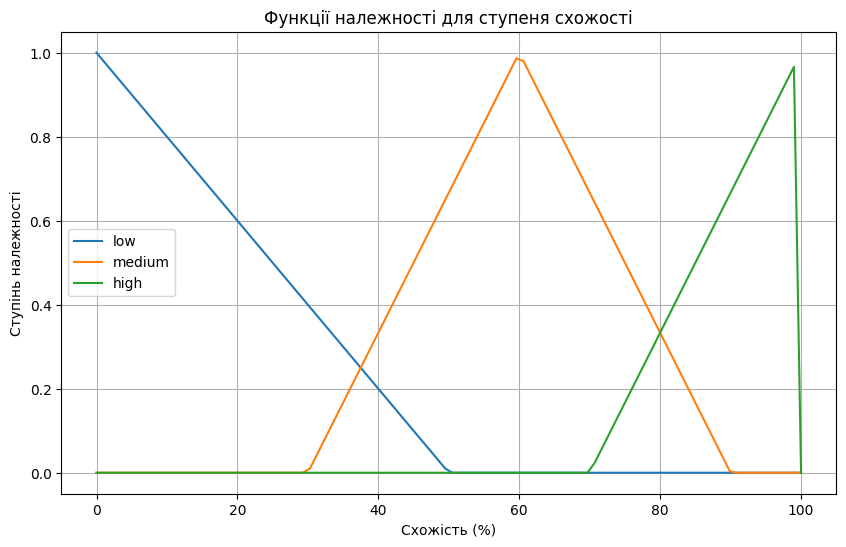

In [156]:
decider.plot()

low : 0.20 | medium : 0.33 | high : 0.00 | 


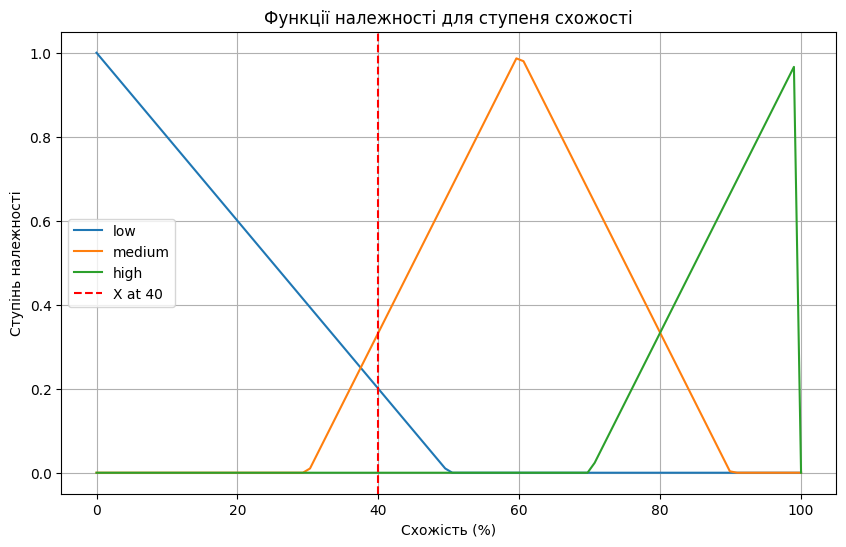

[0.2, 0.3333333333333333, 0]

In [169]:
decider.decide_and_plot(40)